<a href="https://colab.research.google.com/github/bill7845/colab_repo/blob/master/dacon_%EC%A0%9C%EC%A3%BC%EC%B9%B4%EB%93%9C%EC%82%AC%EC%9A%A9%EB%9F%89%EC%98%88%EC%B8%A1/NOTE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < DACON - 제주 빅데이터 경진대회(카드 사용금액 예측) >
---

<br>

## Day 2 정리
  * Q&A 읽고 정리

<br>

* Q. 이용 고객수(CSTMR_CNT)가 이용횟수(CNT)보다 많은 경우?
  * A
    * 카드 승인 후 승인 취소 고객이 존재
    * ex) A,B,C가 각각 1만원,2만원,3만원 결제 후 C가 승인 취소한다면 이용자 수는 3명 이용건수는 2건, 이용 금액은 1만원+2만원=3만원으로 집계됨.

<br>

* Q. 예측 시점?
  * A
    * 1. 1차 공개되는 데이터는 2019.01~2020.03까지의 데이터임
    * 2. Public Score 기간 동안은 1에서 주어진 데이터로 2020.04월 데이터를 예측해야함. (평가지표 RMSLE, 제주지역에 3배 가중치 부여)
    * 3. Public Score 기간 종료 후 2020.04 데이터를 추가로 공개
    * 4. Final Score는 2019.01~2020.04의 데이터를 바탕으로 2020.07월을 예측해야함.

<br>

* Q. 거래 내역이 없는 경우? (ex. 강원지역의 그외 기타 분류안된 오락관련 서비스업의 경우 19년 5월에 2건이 전부임)
  * A. 데이터가 나타나지 않는 경우 크게 2가지 경우임.
    * 1. 기간 내 카드 소비가 발생하지 않는 경우.
    * 2. 이용자 수가 적어 비식별화 조치로 데이터가 삭제된 경우. (대부분 여기에 해당)
  * 비식별화 조치로 삭제된 데이터 금액은 전체 사용액 대비 상당히 낮은 비율임.
  * 모든 기간에서(2019.01~2020.03) 집계에 빠져있는 업종이라도 사용량이 많다면 이후 데이터(2020.04, 2020.07)에서 집계될 수 있음

<br>


* 평가 지표(RMSLE)에 관한 정보
  * RMSLE 특성상 큰 금액을 비슷하게 예측하는 것보다 작은 금액을 큰 차이 없이 예측하는것이 더 나은 전략일 수 있음.
  * RMSLE 특성상 실제값이 0이거나 예측값이 0인데 조금이라도 예측값,실제값과 다르면 큰 페널티를 받음 따라서, 지난 달 결제금액이 0원이였던 지역/업종의 예측값을 매뉴얼하게 0으로 바꿀것을 추천. (or 1로)

<br>

* lagging에 대해..
  * Public Score기간에는 lagging을 1달~3달 등 자유롭게 사용가능. but Final LeaderBord기간의 7월 금액 예측에는 앞서 사용하였던 모델을 그대로 적용불가(2020.05,2020.06데이터 없음) 

<br>

* submission score
  * dacon base line : 7.09526 , 188위 ( 2020.06.22 )

In [4]:
## import libarary

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
# !apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

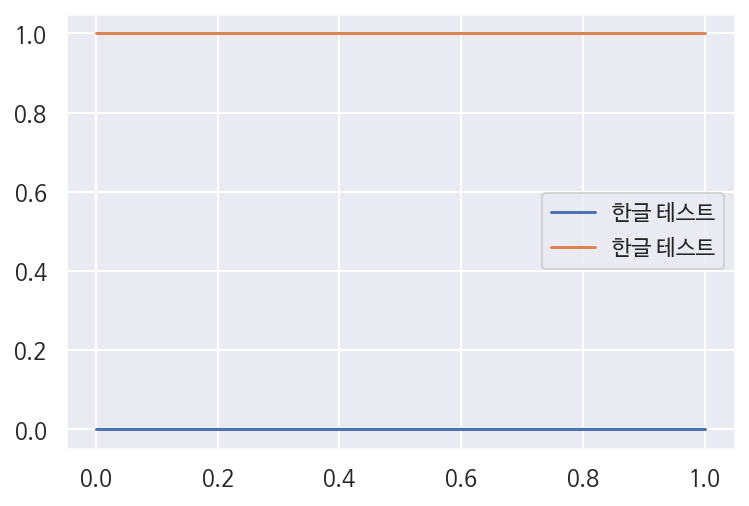

In [6]:
plt.plot(([0,1],[0,1]),label="한글 테스트")
plt.legend()
plt.show()

In [7]:
data = pd.read_csv('/content/drive/My Drive/Colab code/dacon_카드사용액 예측/data/201901-202003.csv') # data load
submission = pd.read_csv('/content/drive/My Drive/Colab code/dacon_카드사용액 예측/data/submission.csv')

In [8]:
def grap_year(data): # year 
    data = str(data)
    return int(data[:4])

def grap_month(data): # month 
    data = str(data)
    return int(data[4:])

data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
# data = data.drop(['REG_YYMM'], axis=1) 

In [9]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [10]:
# 결측값
data.isnull().sum()

REG_YYMM             0
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
year                 0
month                0
dtype: int64

In [11]:
# CARD_CCG_NM(카드사용처 시,군,구 정보) 결측값은 '세종'시에 한해서만 발생.
# CARD_CCG_NM 결측값을 '세종'으로 대체
print(data[data['CARD_CCG_NM'].isnull()]['CARD_SIDO_NM'].value_counts())

# HOM_CCG_NM(카드사용자의 시,군,구 정보) 결측값도 동일.
print(data[data['HOM_CCG_NM'].isnull()]['HOM_SIDO_NM'].value_counts())

data = data.fillna('세종')

세종    87213
Name: CARD_SIDO_NM, dtype: int64
세종    147787
Name: HOM_SIDO_NM, dtype: int64


In [12]:
# 지역 unique value
print(data['CARD_SIDO_NM'].unique())
print(data['STD_CLSS_NM'].unique())

['강원' '경기' '경남' '경북' '광주' '대구' '대전' '부산' '서울' '세종' '울산' '인천' '전남' '전북'
 '제주' '충남' '충북']
['건강보조식품 소매업' '골프장 운영업' '과실 및 채소 소매업' '관광 민예품 및 선물용품 소매업'
 '그외 기타 스포츠시설 운영업' '그외 기타 종합 소매업' '기타 대형 종합 소매업' '기타 외국식 음식점업' '기타 주점업'
 '기타음식료품위주종합소매업' '마사지업' '비알콜 음료점업' '빵 및 과자류 소매업' '서양식 음식점업' '수산물 소매업'
 '슈퍼마켓' '스포츠 및 레크레이션 용품 임대업' '여관업' '욕탕업' '육류 소매업' '일반유흥 주점업' '일식 음식점업'
 '전시 및 행사 대행업' '중식 음식점업' '차량용 가스 충전업' '차량용 주유소 운영업' '체인화 편의점'
 '피자 햄버거 샌드위치 및 유사 음식점업' '한식 음식점업' '호텔업' '화장품 및 방향제 소매업' '휴양콘도 운영업' '여행사업'
 '자동차 임대업' '면세점' '버스 운송업' '택시 운송업' '기타 수상오락 서비스업' '내항 여객 운송업'
 '그외 기타 분류안된 오락관련 서비스업' '정기 항공 운송업']


Text(0.5, 1.0, '서비스 등장빈도')

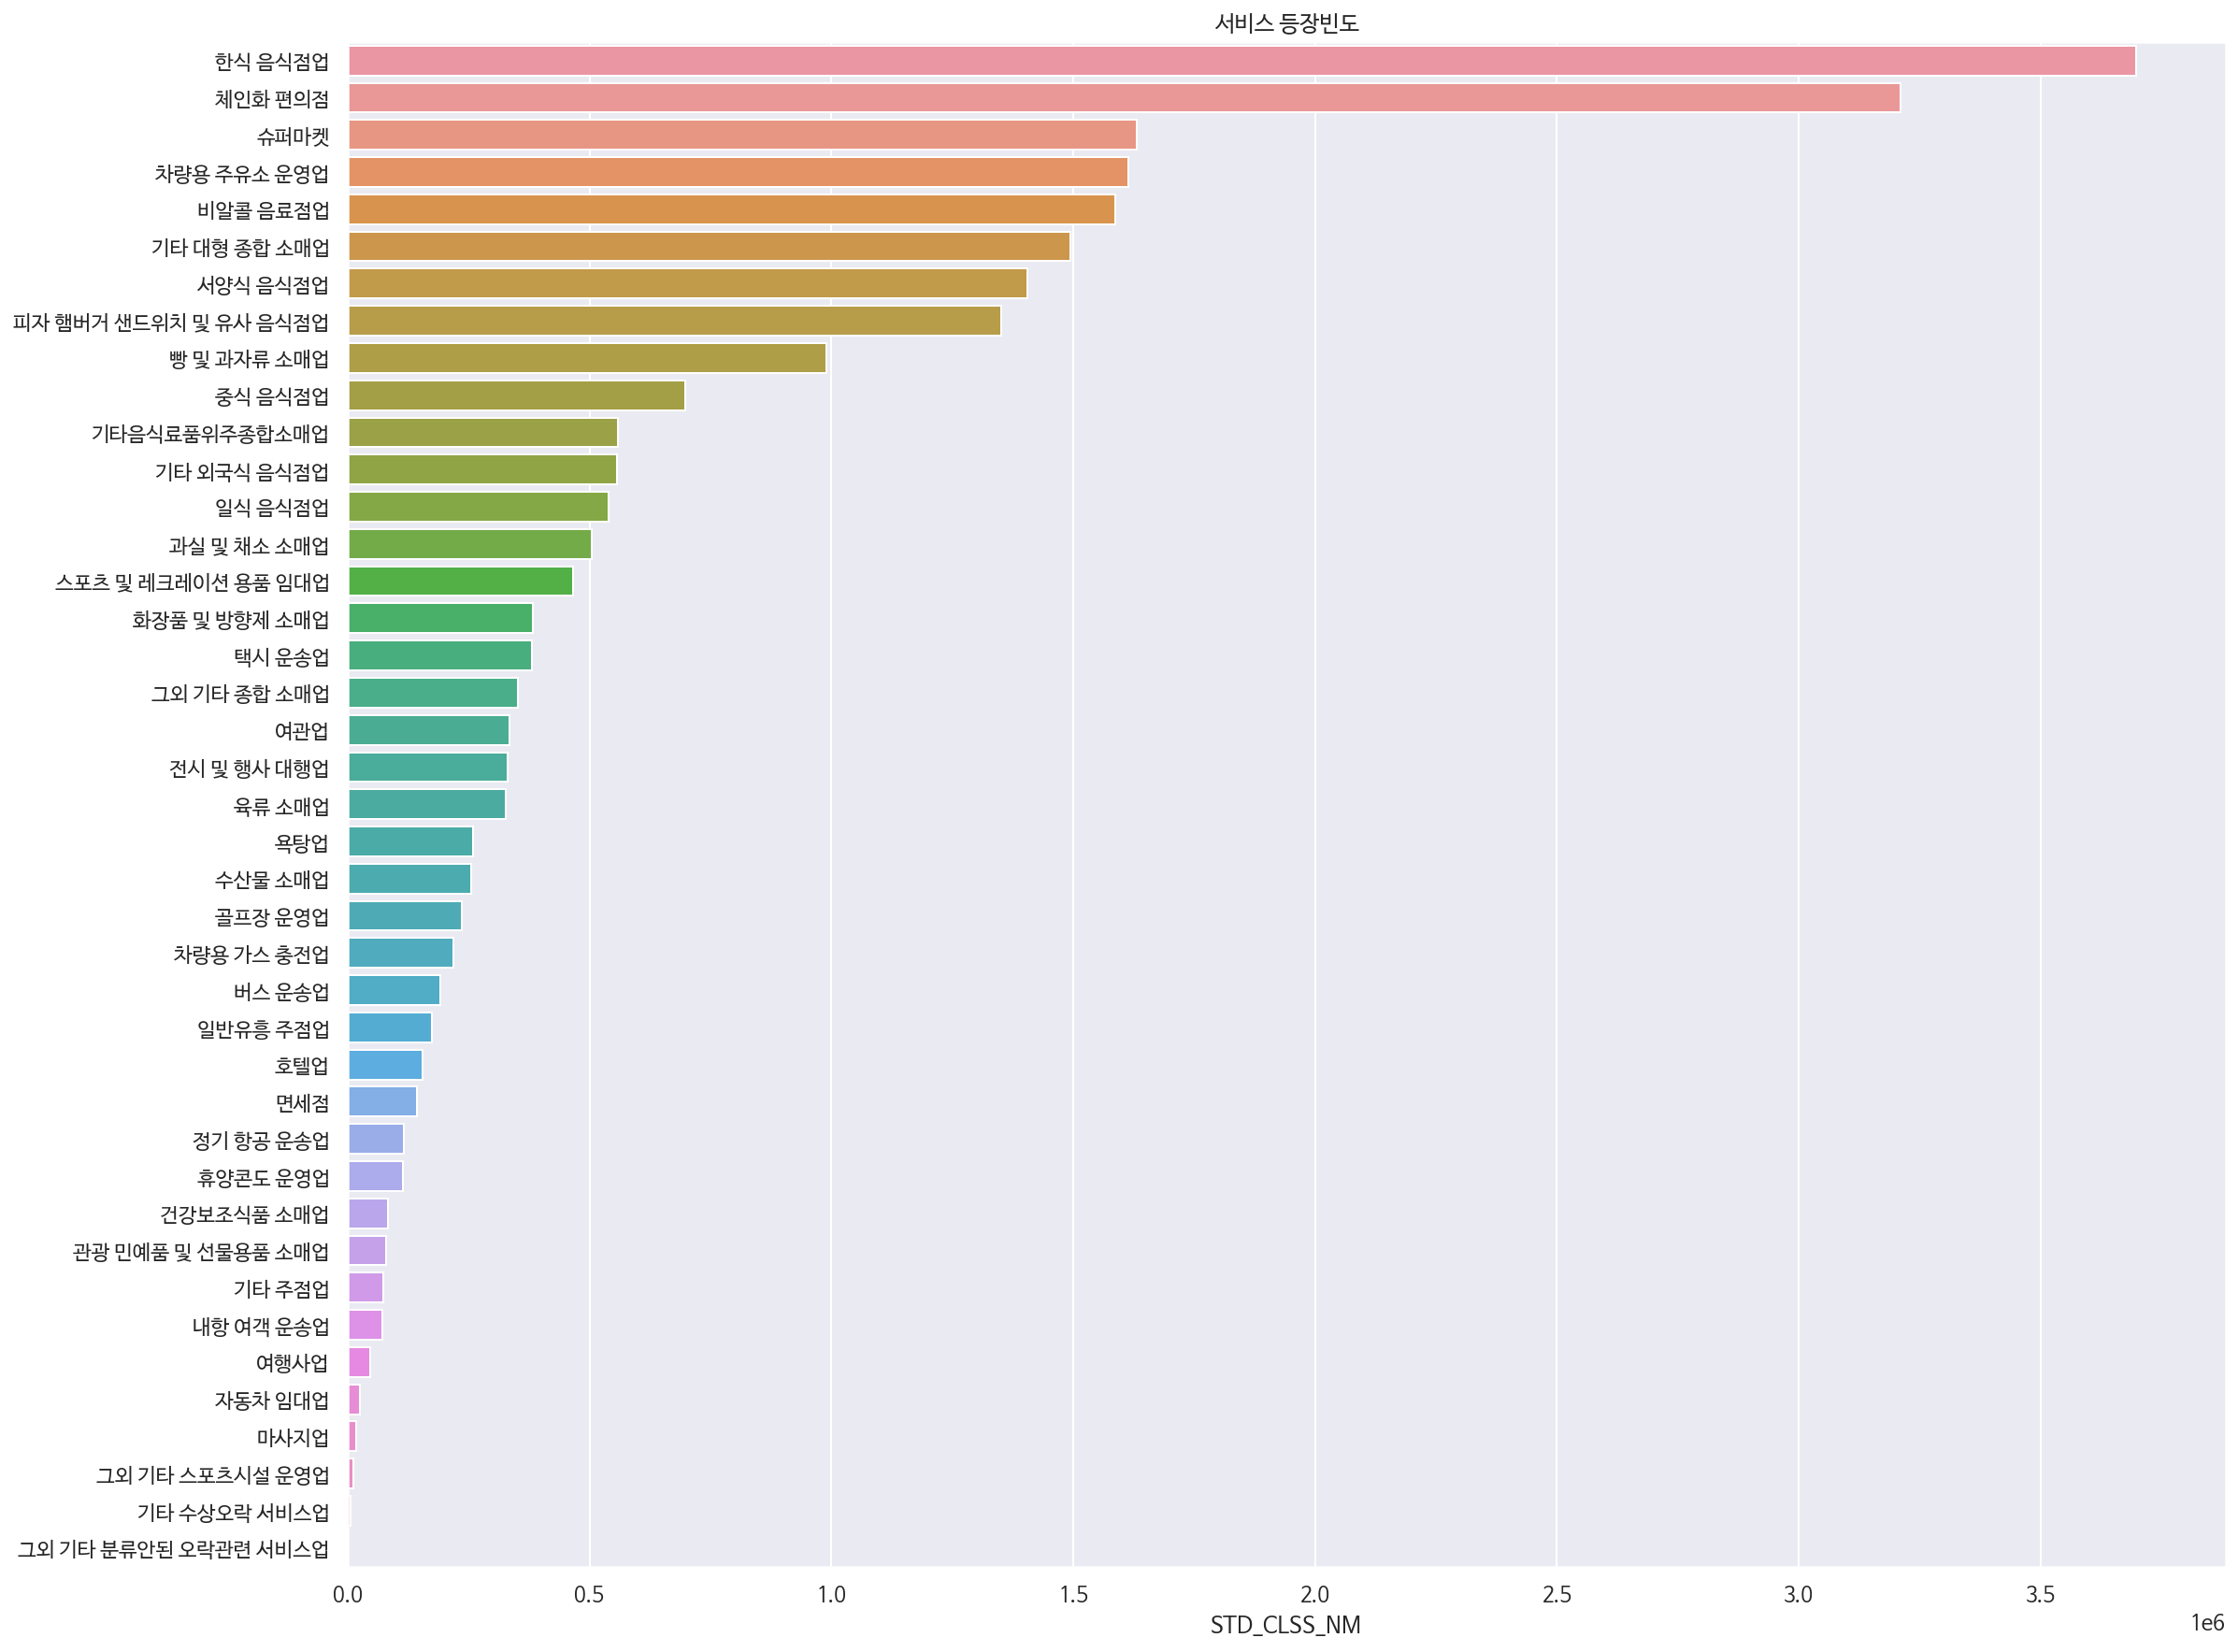

In [13]:
fig = plt.figure(figsize=(18,15))
sns.barplot(x=data['STD_CLSS_NM'].value_counts(), y=data['STD_CLSS_NM'].value_counts().index)
plt.title('서비스 등장빈도')

* 한식음식점, 체인편의점이 높은 비중을 차지.
* 기타 수상오락 서비스업, 그외 기타 분류안된 오락관련 서비스업 등 등장빈도가 거의 없는 서비스도 존재

In [14]:
# 각 시,도 별 업종 빈도
grouped_sido_service = data.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])[['STD_CLSS_NM']].count()
display(grouped_sido_service)

STD_CLSS_NM
CARD_SIDO_NM STD_CLSS_NM                       
강원           건강보조식품 소매업                    1480
             골프장 운영업                      32089
             과실 및 채소 소매업                  27154
             관광 민예품 및 선물용품 소매업             4428
             그외 기타 분류안된 오락관련 서비스업             2
...                                         ...
충북           피자 햄버거 샌드위치 및 유사 음식점업        36079
             한식 음식점업                     204802
             호텔업                           1307
             화장품 및 방향제 소매업                 7445
             휴양콘도 운영업                      5298

[650 rows x 1 columns]

* 각 시,도별 상,하위 업종 top3를 살펴본다.

In [51]:
grouped_sido_service_unstack = grouped_sido_service.unstack()
display(grouped_sido_service_unstack)

for idx,val in enumerate(grouped_sido_service_unstack.index):
  print("######")
  print(val+"지역")
  print("업종 상위 3 :",grouped_sido_service_unstack.iloc[idx].sort_values(ascending=False)[:5]['STD_CLSS_NM'].index.values)
  print("업종 하위 3 :",grouped_sido_service_unstack.iloc[idx].sort_values(ascending=False)[-5:]['STD_CLSS_NM'].index.values)
  print("###### \n")

STD_CLSS_NM                       ...                                
STD_CLSS_NM   건강보조식품 소매업  골프장 운영업 과실 및 채소 소매업  ...      호텔업 화장품 및 방향제 소매업 휴양콘도 운영업
CARD_SIDO_NM                                   ...                                
강원                1480.0  32089.0     27154.0  ...  16659.0        6439.0  50330.0
경기               15456.0  61989.0     94589.0  ...   3847.0       59748.0   6566.0
경남                3294.0  24568.0     23327.0  ...   1190.0       14632.0   8001.0
경북                2781.0  22756.0     23545.0  ...   9805.0        9371.0   6851.0
광주                2285.0   2049.0     12544.0  ...   1092.0        8572.0      NaN
대구                3197.0   1887.0     14409.0  ...   4221.0       15141.0      NaN
대전                2039.0   1091.0      7386.0  ...   2294.0        7914.0      NaN
부산                6137.0   7726.0     77713.0  ...  20173.0       39431.0   8196.0
서울               19570.0   4036.0     92586.0  ...  69345.0      166333.0      NaN
세종                 145.0   1309.0      2131.0  ...      NaN         708.0      NaN
울산                 878.0   3283.0      5369.0  ...   2211.0        4659.0      NaN
인천                4411.0   8855.0     33325.0  ...  11150.0       13241.0      NaN
전남                1611.0  17058.0     20742.0  ...    863.0        7008.0   5940.0
전북                2223.0  11500.0     18933.0  ...     99.0        7312.0   8340.0
제주                 458.0   3975.0     19599.0  ...   6592.0        3264.0   7515.0
충남               15560.0  13852.0     20635.0  ...   4461.0       12495.0   7884.0
충북                2332.0  18531.0     10492.0  ...   1307.0        7445.0   5298.0

[17 rows x 41 columns]

######
강원지역
업종 상위 3 : ['한식 음식점업' '체인화 편의점' '슈퍼마켓' '차량용 주유소 운영업' '비알콜 음료점업']
업종 하위 3 : ['자동차 임대업' '택시 운송업' '면세점' '그외 기타 분류안된 오락관련 서비스업' '정기 항공 운송업']
###### 

######
경기지역
업종 상위 3 : ['한식 음식점업' '체인화 편의점' '기타 대형 종합 소매업' '차량용 주유소 운영업' '슈퍼마켓']
업종 하위 3 : ['여행사업' '내항 여객 운송업' '그외 기타 분류안된 오락관련 서비스업' '면세점' '정기 항공 운송업']
###### 

######
경남지역
업종 상위 3 : ['한식 음식점업' '체인화 편의점' '차량용 주유소 운영업' '슈퍼마켓' '기타 대형 종합 소매업']
업종 하위 3 : ['여행사업' '자동차 임대업' '그외 기타 분류안된 오락관련 서비스업' '면세점' '정기 항공 운송업']
###### 

######
경북지역
업종 상위 3 : ['한식 음식점업' '차량용 주유소 운영업' '체인화 편의점' '슈퍼마켓' '서양식 음식점업']
업종 하위 3 : ['자동차 임대업' '여행사업' '그외 기타 분류안된 오락관련 서비스업' '면세점' '정기 항공 운송업']
###### 

######
광주지역
업종 상위 3 : ['체인화 편의점' '한식 음식점업' '슈퍼마켓' '기타 대형 종합 소매업' '비알콜 음료점업']
업종 하위 3 : ['여행사업' '그외 기타 분류안된 오락관련 서비스업' '면세점' '정기 항공 운송업' '휴양콘도 운영업']
###### 

######
대구지역
업종 상위 3 : ['체인화 편의점' '한식 음식점업' '슈퍼마켓' '비알콜 음료점업' '서양식 음식점업']
업종 하위 3 : ['여행사업' '그외 기타 분류안된 오락관련 서비스업' '내항 여객 운송업' '정기 항공 운송업' '휴양콘도 운영업']
###### 

######
대전지역
업종 상위 3 : ['체인화 편의점' '한식 음식점업' '빵 및 과자류 

* 제주도 지역을 자세히 살펴본다.

In [16]:
print("제주도 업종 상위 10 :",grouped_sido_service_unstack.iloc[-3].sort_values(ascending=False)[:5]['STD_CLSS_NM'].index.values)
print("제주도 업종 하위 10 :",grouped_sido_service_unstack.iloc[-3].sort_values(ascending=False)[-5:]['STD_CLSS_NM'].index.values)

제주도 업종 상위 10 : ['한식 음식점업' '체인화 편의점' '면세점' '서양식 음식점업' '정기 항공 운송업']
제주도 업종 하위 10 : ['그외 기타 분류안된 오락관련 서비스업' '마사지업' '택시 운송업' '기타 수상오락 서비스업' '버스 운송업']


In [17]:
# REG_YYMM 을 datetime type 변경
data['REG_YYMM'] = pd.to_datetime(data['REG_YYMM'],format="%Y%m")

sample_jeju = data[data['CARD_SIDO_NM'] == '제주'] # 제주지역만 sampling

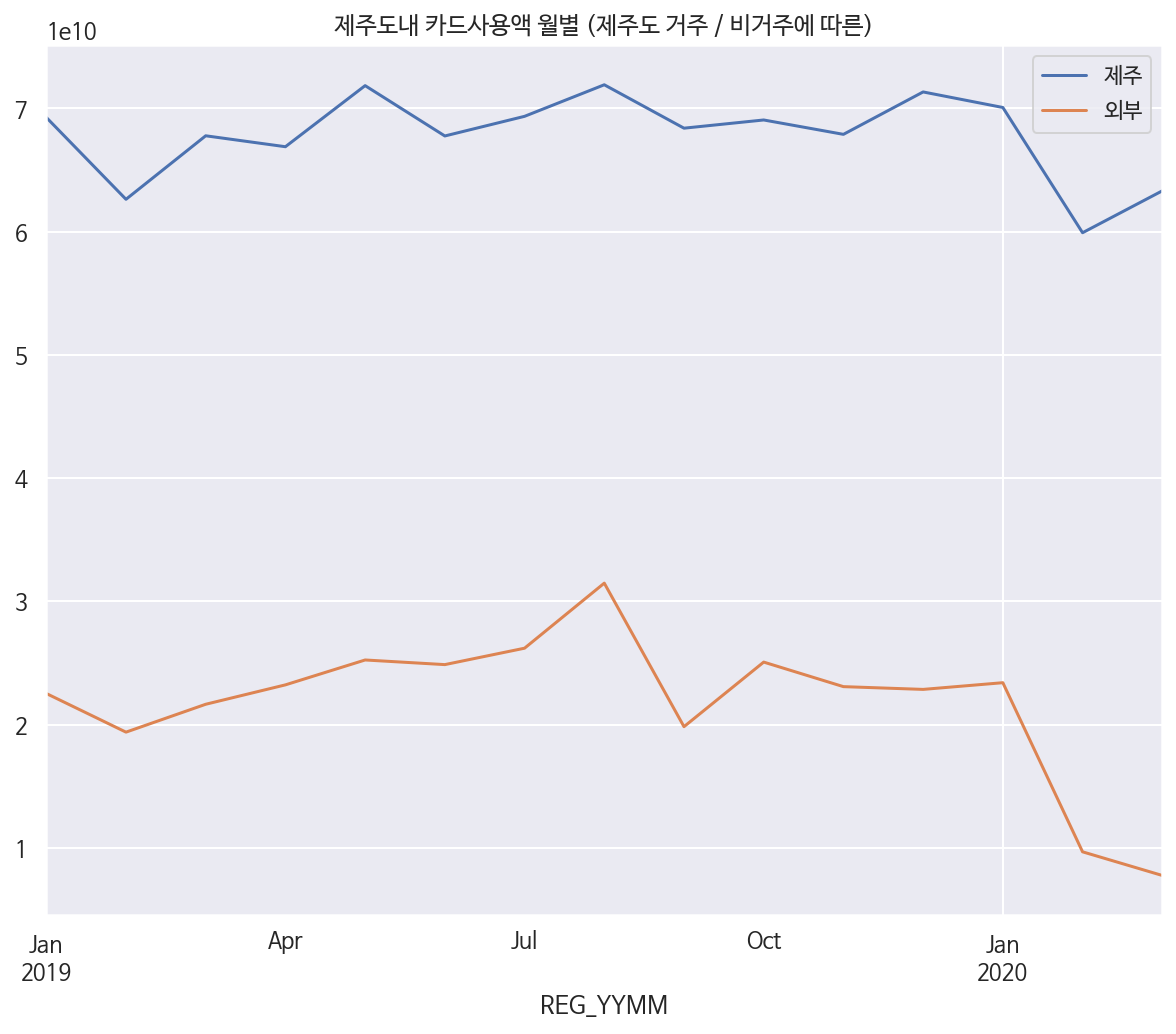

In [18]:
## 제주도내 카드사용액 월별 (제주도 거주 / 비거주에 따른)

plt.figure(figsize=(10,8))
sample_jeju.query("HOM_SIDO_NM == '제주'").set_index('REG_YYMM').resample('M')['AMT'].sum().plot(label='제주')
sample_jeju.query("HOM_SIDO_NM != '제주'").set_index('REG_YYMM').resample('M')['AMT'].sum().plot(label='외부')
plt.title("제주도내 카드사용액 월별 (제주도 거주 / 비거주에 따른)")
plt.legend()

In [19]:
## 제주도내 월별 상점 이용 고객 수 중 비거주 고객이 차지하는 비율

import plotly.offline as pyo
from plotly import graph_objs as go

tmp_a = sample_jeju.set_index('REG_YYMM').resample('M')['CSTMR_CNT'].sum() # 제주도 월별 전체 고객 수

trace1 = go.Line(x=tmp_a.index, 
                 y=tmp_a.values,
                 name='전체 고객')

tmp_b = sample_jeju.query("HOM_SIDO_NM != '제주'").set_index('REG_YYMM').resample('M')['CSTMR_CNT'].sum() # 제주도 월별 비거주 고객 수

trace2 = go.Bar(x=tmp_b.index, 
                y=tmp_b.values, 
                text=round(tmp_b/tmp_a, 2).values,
                textposition='auto',
                name='제주도 비거주 고객')


tmp_data = [trace1, trace2]
layout = go.Layout(title='제주도내 월별 상점 이용 고객 수 중 비거주 고객이 차지하는 비율')
fig = go.Figure(data=tmp_data, layout=layout)
pyo.iplot(fig)

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




* 여름철에 비거주 제주도 고객 수 가장 높음.
* 코로나 유행 이후인 2,3월의 경우 전체 고객 수, 외부 고객 수 모두 전년 동월 대비 급락함.

In [61]:
# 기간 내 전체 카드 사용금액에서 업종별 가장 높은 순위 top N

totalSum_jeju = sample_jeju['AMT'].sum() # 전체 카드 사용액
STD_sum = sample_jeju.groupby('STD_CLSS_NM')['AMT'].sum() ## 업종 별

amount_rate = round(STD_sum / totalSum_jeju,3)
print("-제주- 전체 카드사용액 대비 업종별 카드사용액 비율",amount_rate.sort_values(ascending=False)[:10])
print('##################################')


totalSum_jeju_july = sample_jeju.query("month==7")['AMT'].sum() # 7월 전체 카드 사용액
STD_sum_july = sample_jeju.query("month==7").groupby('STD_CLSS_NM')['AMT'].sum() ## 업종 별 7월

amount_rate_july = round(STD_sum_july / totalSum_jeju_july,3)
print("-제주- 7월 전체 카드사용액 대비 업종별 카드사용액 비율",amount_rate_july.sort_values(ascending=False)[:10])
print('##################################')

totalSum_jeju_aug = sample_jeju.query("month==8")['AMT'].sum() # 8월 전체 카드 사용액
STD_sum_aug = sample_jeju.query("month==8").groupby('STD_CLSS_NM')['AMT'].sum() ## 업종 별 8월

amount_rate_aug = round(STD_sum_aug / totalSum_jeju_aug,3)
print("-제주- 8월 전체 카드사용액 대비 업종별 카드사용액 비율",amount_rate_aug.sort_values(ascending=False)[:10])
print('##################################')

totalSum_jeju_startKorona = sample_jeju.query("(month==2) and (year==2020)")['AMT'].sum() # 2020년 2월 전체 카드 사용액
STD_sum_startKorona = sample_jeju.query("(month==2) and (year==2020)").groupby('STD_CLSS_NM')['AMT'].sum() ## 업종 별 2020년 2월

amount_rate_startKorona = round(STD_sum_startKorona / totalSum_jeju_startKorona,3)
print("-제주- 2020년 2월 전체 카드사용액 대비 업종별 카드사용액 비율",amount_rate_startKorona.sort_values(ascending=False)[:10])
print('##################################')

totalSum_jeju_startKorona2 = sample_jeju.query("(month==3) and (year==2020)")['AMT'].sum() # 2020년 3월 전체 카드 사용액
STD_sum_startKorona2 = sample_jeju.query("(month==3) and (year==2020)").groupby('STD_CLSS_NM')['AMT'].sum() ## 업종 별 2020년 3월

amount_rate_startKorona2 = round(STD_sum_startKorona2 / totalSum_jeju_startKorona2,3)
print("-제주- 2020년 3월 전체 카드사용액 대비 업종별 카드사용액 비율",amount_rate_startKorona2.sort_values(ascending=False)[:10])
print('##################################')


-제주- 전체 카드사용액 대비 업종별 카드사용액 비율 STD_CLSS_NM
한식 음식점업               0.229
슈퍼마켓                  0.112
차량용 주유소 운영업           0.099
면세점                   0.080
체인화 편의점               0.075
기타 대형 종합 소매업          0.058
기타음식료품위주종합소매업         0.035
정기 항공 운송업             0.033
그외 기타 종합 소매업          0.026
스포츠 및 레크레이션 용품 임대업    0.025
Name: AMT, dtype: float64
##################################
-제주- 7월 전체 카드사용액 대비 업종별 카드사용액 비율 STD_CLSS_NM
한식 음식점업          0.232
슈퍼마켓             0.109
차량용 주유소 운영업      0.089
체인화 편의점          0.080
면세점              0.078
기타 대형 종합 소매업     0.060
정기 항공 운송업        0.046
기타음식료품위주종합소매업    0.034
서양식 음식점업         0.027
그외 기타 종합 소매업     0.023
Name: AMT, dtype: float64
##################################
-제주- 8월 전체 카드사용액 대비 업종별 카드사용액 비율 STD_CLSS_NM
한식 음식점업          0.242
슈퍼마켓             0.106
차량용 주유소 운영업      0.093
체인화 편의점          0.081
면세점              0.079
기타 대형 종합 소매업     0.055
기타음식료품위주종합소매업    0.038
정기 항공 운송업        0.029
서양식 음식점업         0.029
그외 기타 종합 소매업     0.023
Name: 

* 업종별 카드사용액 비중을 살펴봄.
  * 전체 기간(2019~2020.03)을 기준으로 한국 음식점업,슈퍼마켓,주유소가 top3를 차지함
  * 면세점, 항공 운수업, 스포츠 및 레크레이션 용품 임대업이 top10이내에 위치함


* 휴가철인 7,8월은 전체기간과 큰 차이를 보이지 않음

* 코로나가 본격적으로 시작한 2020년 2월과 3월에는 전체 카드사용액에서 면세점이 차지하는 비율이 낮아졌으며 항공운수업의 경우 top10 내에서 벗어남